In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import boto3
import json

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1615921700910_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sm_client = boto3.client('secretsmanager',region_name='us-west-2')
secret_value = sm_client.get_secret_value(SecretId = 'emr_spark_qa')
username = json.loads(secret_value['SecretString'])['emr_spark_username']
password = json.loads(secret_value['SecretString'])['emr_spark_password']

#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : username,
  'sfPassword' : password,
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user=username,
    password=password
    )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#Careful not to get SSC for SC
#PM,SC - contains(r.observations, ',SC')
#Look for comma before, will always be before bc 'PM' is alphabetically before SC


#HAVE OBS LABEL IN QUESTION
query_testing = "select distinct r.ugc_id,  r.review_headline, r.review_comments, r.review_rating, \
case when (contains(r.observations, 'SA') or contains(r.observations, ',SC')) then 1 else 0 end as SASC \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') and contains(r.observations, 'PM') \
and not contains(r.observations, 'IA') and not contains(r.observations, 'IR') \
and (contains(r.observations, 'SA') or contains(r.observations, ',SC')) \
and r.created_date > '2019-01-01' \
"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID                             REVIEW_HEADLINE  ... REVIEW_RATING  SASC
0   321313837             Not what I expect from Skechers  ...             1     1
1   321296736                               Uncomfortable  ...             1     1
2   321325746                             Waste of money!  ...             1     1
3   321319245                                    Burns!!!  ...             3     1
4   321347009                     Bad for combo oily skin  ...             1     1
..        ...                                         ...  ...           ...   ...
95  308402057                                    NOT SAFE  ...             1     1
96  308418445  The Hartford doesn't work for or with you.  ...             1     1
97  308420067                                    Allergic  ...             1     1
98  326550677  Haltway decent machine, quirky controller.  ...             3     1
99  326640148                 DO NOT BUY IF YOU HAVE PETS  ...             1     1

[10

In [6]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78436 entries, 0 to 78435
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   UGC_ID           78436 non-null  int64 
 1   REVIEW_HEADLINE  78435 non-null  object
 2   REVIEW_COMMENTS  78436 non-null  object
 3   REVIEW_RATING    78436 non-null  int64 
 4   SASC             78436 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.0+ MB

In [7]:
#DONT HAVE OBS LABEL IN QUESTION
query_testing_2 = "select distinct r.ugc_id,  r.review_headline, r.review_comments, r.review_rating, \
case when (contains(r.observations, 'SA') or contains(r.observations, ',SC')) then 1 else 0 end as SASC \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') and contains(r.observations, 'PM') \
and not contains(r.observations, 'IA') and not contains(r.observations, 'IR') \
and not contains(r.observations, 'SA') and not contains(r.observations, ',SC') \
and r.created_date > '2019-01-01' \
"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
reviews_2 = pd.read_sql(query_testing_2, conn)
reviews_2.head(100)
reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14958405 entries, 0 to 14958404
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   UGC_ID           int64  
 1   REVIEW_HEADLINE  object 
 2   REVIEW_COMMENTS  object 
 3   REVIEW_RATING    float64
 4   SASC             int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 570.6+ MB

In [9]:
#Take same # of those without obs as those with obs
#Using limit 500000 is not random, pull in all w/ no labels and then take random sample from there
from random import sample 
reviews_2 = reviews_2.sample(n=78436, random_state=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
reviews_2['SASC'].sum(axis=0)
#reviews_2[reviews_2['SASC']==1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [11]:
reviews = pd.concat([reviews, reviews_2], axis=0)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             UGC_ID                  REVIEW_HEADLINE  ... REVIEW_RATING  SASC
0         321313837  Not what I expect from Skechers  ...           1.0     1
1         321296736                    Uncomfortable  ...           1.0     1
2         321325746                  Waste of money!  ...           1.0     1
3         321319245                         Burns!!!  ...           3.0     1
4         321347009          Bad for combo oily skin  ...           1.0     1
...             ...                              ...  ...           ...   ...
13726921  231970811           BEST CARD FOREVER! Use  ...           5.0     0
3762445   299339473  Moon & star - Beautiful design!  ...           5.0     0
10312174  326785857                   good selection  ...           5.0     0
6101289   249319426      I would recommend this item  ...           5.0     0
1913494   263576879                             Sure  ...           5.0     0

[156872 rows x 5 columns]

In [12]:
reviews['SASC'].sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

78436

In [13]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156872 entries, 0 to 1913494
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   UGC_ID           156872 non-null  int64  
 1   REVIEW_HEADLINE  156860 non-null  object 
 2   REVIEW_COMMENTS  156862 non-null  object 
 3   REVIEW_RATING    156872 non-null  float64
 4   SASC             156872 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.2+ MB

In [14]:
#reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
#        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
reviews['ALL_TEXT'] =  reviews['REVIEW_HEADLINE']  + ' ' + reviews['REVIEW_COMMENTS']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID                             REVIEW_HEADLINE  \
0   321313837  Not what I expect from Skechers              
1   321296736  Uncomfortable                                
2   321325746  Waste of money!                              
3   321319245  Burns!!!                                     
4   321347009  Bad for combo oily skin                      
..        ...                      ...                      
95  308402057  NOT SAFE                                     
96  308418445  The Hartford doesn't work for or with you.   
97  308420067  Allergic                                     
98  326550677  Haltway decent machine, quirky controller.   
99  326640148  DO NOT BUY IF YOU HAVE PETS                  

                                                                                                                                                                                                                                                                           

In [15]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156872 entries, 0 to 1913494
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   UGC_ID           156872 non-null  int64  
 1   REVIEW_HEADLINE  156860 non-null  object 
 2   REVIEW_COMMENTS  156862 non-null  object 
 3   REVIEW_RATING    156872 non-null  float64
 4   SASC             156872 non-null  int64  
 5   ALL_TEXT         156850 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.4+ MB

In [16]:
nlp = spacy.load("en_core_web_lg")

def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
#Some NaN values causing an error when applying word embedding vector
#reviews['ALL_TEXT'].isnull().values.any()

#Remove NaN values
reviews.dropna(inplace=True)
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156850 entries, 0 to 1913494
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   UGC_ID           156850 non-null  int64  
 1   REVIEW_HEADLINE  156850 non-null  object 
 2   REVIEW_COMMENTS  156850 non-null  object 
 3   REVIEW_RATING    156850 non-null  float64
 4   SASC             156850 non-null  int64  
 5   ALL_TEXT         156850 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.4+ MB

In [18]:
reviews['ALL_TEXT'].isnull().values.any()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

False

In [19]:
reviews['vec'] = reviews['ALL_TEXT'].apply(lambda x: get_vec(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
reviews['vec'].shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(156850,)

In [21]:
X_text = reviews['vec'].to_numpy().reshape(-1,1)
X_text.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(156850, 1)

In [22]:
#300 bc there are 300 dimensions in the spacy package
X_text = np.concatenate(np.concatenate(X_text, axis =0), axis = 0).reshape(-1, 300)
X_text.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(156850, 300)

In [23]:
X= X_text

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:

y = reviews[['SASC']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          SASC
0         1   
1         1   
2         1   
3         1   
4         1   
...      ..   
13726921  0   
3762445   0   
10312174  0   
6101289   0   
1913494   0   

[156850 rows x 1 columns]

In [25]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SASC    78435
dtype: int64

In [26]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[-0.28062     0.192976   -0.27790332 ... -0.02478767  0.08129366
   0.30257332]
 [-0.08859308  0.1348217  -0.13896924 ... -0.10784607  0.05305311
   0.1717346 ]
 [ 0.00852548  0.15566763 -0.24888031 ... -0.10915678  0.07409047
   0.06496055]
 ...
 [ 0.03771799  0.10729875 -0.27322048 ... -0.06788722  0.07721444
   0.09571049]
 [ 0.11916443  0.15799953 -0.12536433 ... -0.04005639 -0.05457842
   0.08534879]
 [ 0.09449061  0.12727132 -0.07098465 ... -0.08279277  0.02801113
   0.11550773]]

In [28]:
xtrain_final = xtrain
xtest_final = xtest

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000, solver = 'lbfgs')
clf = lr


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
#Support Vector Machine model
#clf = svm.SVC(probability=True)

#Need to change input type of y for training model
#ytrain = ytrain['NR'].ravel()
#ytrain.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
#Train model
clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegression(max_iter=1000)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

In [32]:
#ytrain.dtypes
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SASC    62748
dtype: int64

In [33]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
%matplotlib inline

In [36]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest, values_format = '.5g')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

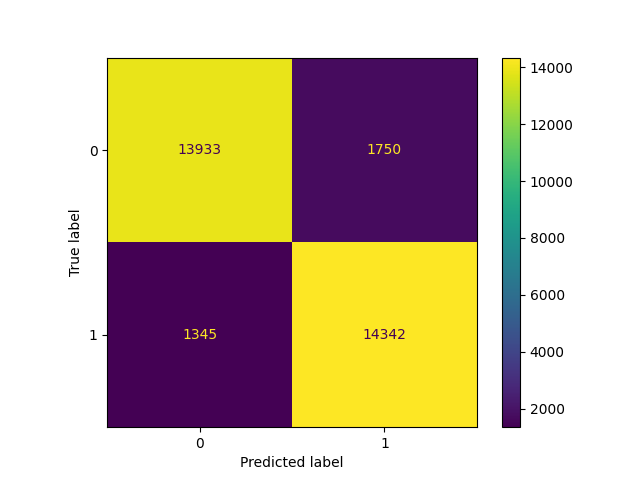

In [37]:
%matplot plt

In [ ]:
xtest['SASC'] = ytest
xtest['model_SASC'] = y_pred

In [ ]:
xtest.info()

In [ ]:
from pyspark.sql.types import *

mySchema = StructType([StructField("UGC_ID", StringType(), True)\
,StructField("REVIEW_HEADLINE", StringType(), True)\
,StructField("REVIEW_COMMENTS", StringType(), True)\
,StructField("REVIEW_RATING", FloatType(), True)\
,StructField("ALL_TEXT", StringType(), True)\
,StructField("SASC", IntegerType(), True)\
,StructField("model_SASC", IntegerType(), True)])   

In [39]:
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : username,
  'sfPassword' : password,
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
#Turn into spark dataframe in order to write to Snowflake
#Couldn't get write_pandas() to work to write directly from pandas to Snowflake
xtest = spark.createDataFrame(xtest, schema=mySchema)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
xtest.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions) \
    .option("dbtable","SASC_test1").mode("append").save()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.901338858782276
Precision is:  0.891250310713398
Recall is:  0.9142602154650348
F1 Score is:  0.9026086409263979

In [39]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     15683
           1       0.89      0.91      0.90     15687

    accuracy                           0.90     31370
   macro avg       0.90      0.90      0.90     31370
weighted avg       0.90      0.90      0.90     31370

In [40]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)
#print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

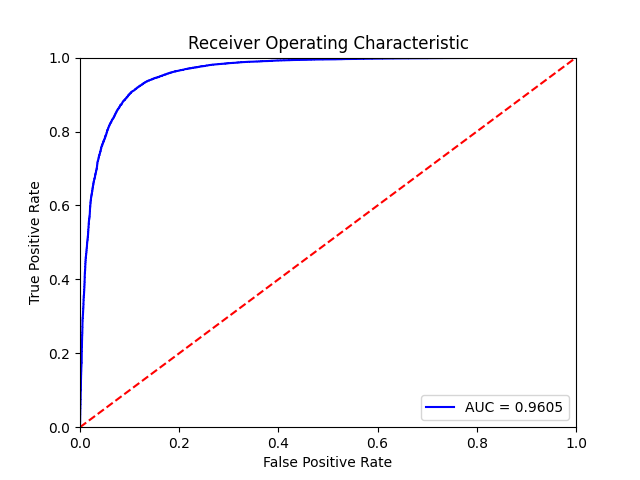

In [43]:
%matplot plt

In [44]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.48573213197693527
Optimal tpr value: 0.91955122075604
Optimal fpr value: 0.11592169865459415

In [45]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.9018170226330889
Precision is:  0.8880748630179154
Recall is:  0.91955122075604
F1 Score is:  0.9035389915440025

In [47]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

31370

In [66]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
pr_auc = metrics.auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['CS']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

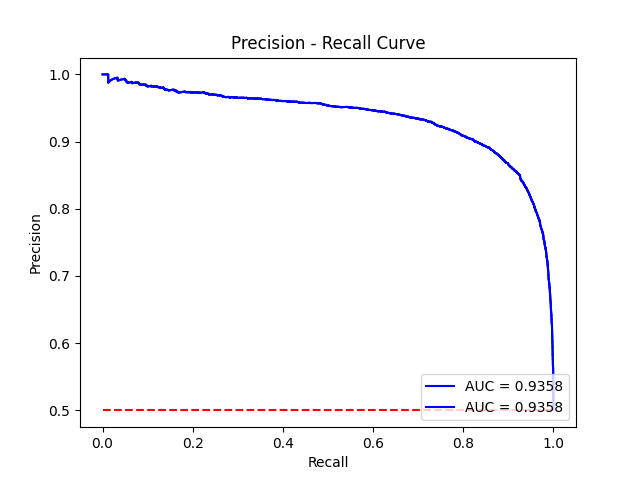

In [71]:
%matplot plt

In [72]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.414175, F-Score=0.886
Recall=0.925221
Precision=0.850173

In [73]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

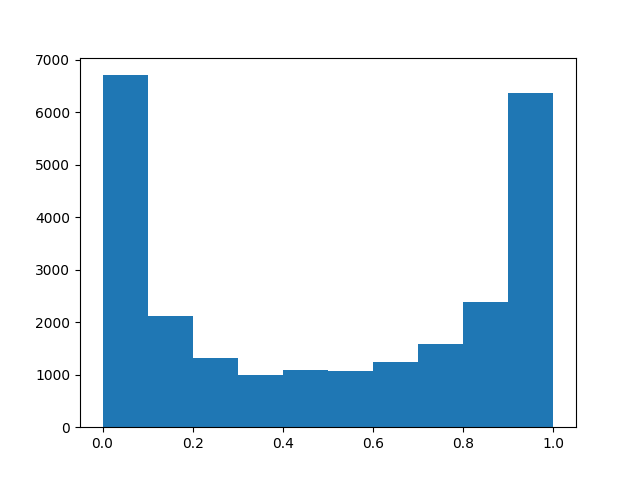

In [75]:
%matplot plt

In [76]:
preds_df = pd.DataFrame(data=preds, columns = ['pred_prob'])
#preds_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
ytest.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
hist_plot_data = pd.concat([ytest, preds_df], axis = 1)
#hist_plot_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
CS_0 = hist_plot_data.loc[hist_plot_data.CS == 0, 'pred_prob']
CS_1 = hist_plot_data.loc[hist_plot_data.CS == 1, 'pred_prob']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
kwargs = dict(alpha=0.5, bins=20)

plt.hist(CS_0, **kwargs, color='b', label='CS=0')
plt.hist(CS_1, **kwargs, color='g', label='CS=1')
plt.gca().set(title='Histogram of CS Label Probs', ylabel='Frequency', xlabel = 'Predicted Probability')
plt.legend();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

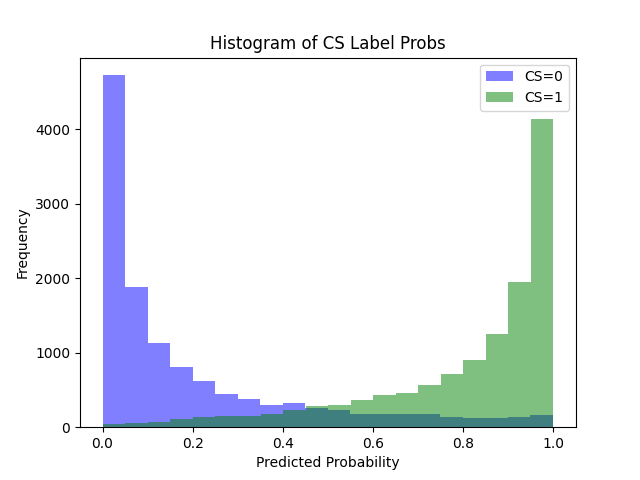

In [83]:
%matplot plt

In [316]:
#Amount of data that is actually 0 but predicted as 1 with probability > 80%
hist_plot_data.loc[(hist_plot_data.NR == 0) & (hist_plot_data.pred_prob > 0.8)].count()
#3233 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3233
pred_prob    3233
dtype: int64

In [317]:
#Amount of data that is actually 1 but predicted as 0 with probability < 20%
hist_plot_data.loc[(hist_plot_data.NR == 1) & (hist_plot_data.pred_prob < 0.2)].count()
#3683 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3683
pred_prob    3683
dtype: int64

In [318]:
#Amount of data (0 or 1) that is between probabilities 20% - 80%
hist_plot_data.loc[(hist_plot_data.pred_prob <0.8) & (hist_plot_data.pred_prob > 0.2)].count()
#47346 / 204885 = ~23%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           47346
pred_prob    47346
dtype: int64

In [161]:
#importance = clf.coef_
#importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:

#feature_names = vectorizer.get_feature_names()
#dense = importance
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [287]:
xtest.reset_index(drop=True, inplace=True)
hist_plot_data.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [303]:
results = pd.concat([xtest, hist_plot_data], axis=1)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [304]:
results['ALL_TEXT'] = results['ALL_TEXT'].astype(str)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [305]:
results_sparkdf = spark.createDataFrame(results)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [306]:
sfOptions2 = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [307]:
 results_sparkdf.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions2) \
    .option("dbtable","MODLABEL_TEST_2").mode("append").save()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…